## Vi kan introdusere uregelmessigheter til værdata ved diverse funksjoner

Værdataen vi har samlet er nokså fullstendig, og uten feilverdier, men ved bruk av enkelte funksjoner kan vi introdusere noen feil, for så å rette de opp igjen etterpå: 

In [ ]:
import pandas as pd
import numpy as np

df2_errors = pd.read_json("../data/df2_data.json") #leser json filen til "df2"

# introduserer uregelmessigheter (NaN til omtrent 6% av verdiene i mean(relative_humidity P1D))
def introduser_NaN(entry):
    entry.loc[entry.sample(frac=0.06).index, 'mean(relative_humidity P1D)'] = np.nan 
    return entry

# introduserer enkelte tallverdier på 570, som ikke gir mening (uteliggere)
def introduser_uteliggere(entry):
    entry.loc[entry.sample(frac=0.04).index, 'mean(air_temperature P1D)'] = 570
    return df2_errors

#Kjører funksjonene og lagrer til ny fil
nan=introduser_NaN(df2_errors)
uteligger=introduser_uteliggere(nan)



uteligger.to_json('../data/df2_errors.json',indent=4)







## Her kan vi visualisere dataen samlet med seaborn og matplotlib

Først kan vi lage en lett visualisering av en av elementene i luftdataen, f eks NO2 over tid. Her har vi laget en graf fra April til slutten av Mai (ca 2 måneder). 

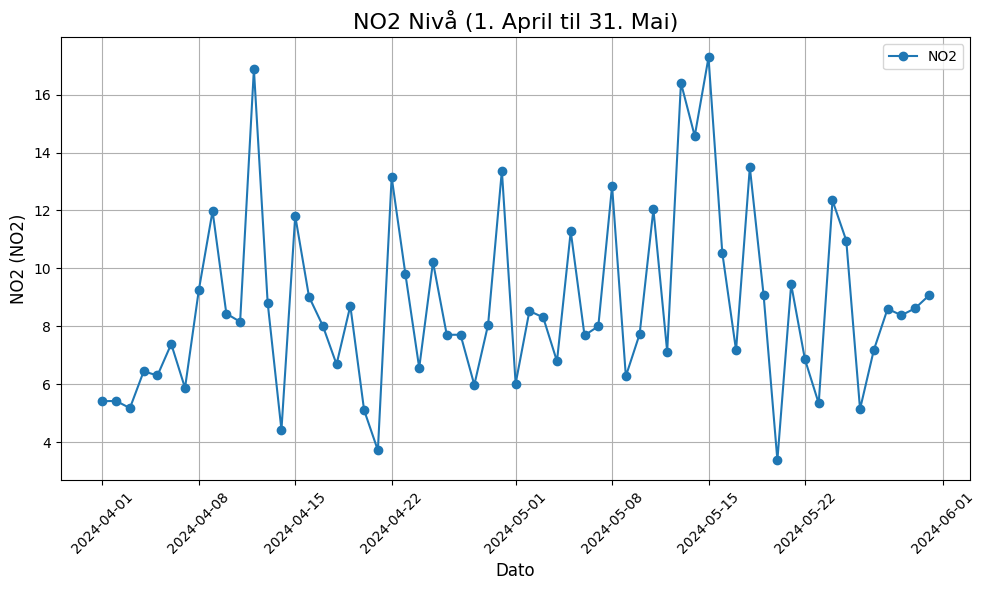

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

Luftdata = pd.read_json('../data/df1_data.json')

# bruker pivot_df filtrerer for dato område
Luftdata["date"] = pd.to_datetime(Luftdata["date"]) 
filtered_df = Luftdata[(Luftdata["date"] >= "2024-04-01") & (Luftdata["date"] <= "2024-05-31")]


# Velger variabel
variable = "NO2"

# Plotter
plt.figure(figsize=(10, 6))
plt.plot(filtered_df["date"], filtered_df[variable], marker="o", label=variable)

# Pynter og justerer grafen
plt.title(f"{variable} Nivå (1. April til 31. Mai)", fontsize=16)
plt.xlabel("Dato", fontsize=12)
plt.ylabel(f"{variable} ({Luftdata[variable].name})", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()


plt.tight_layout()
plt.show()

Om vi ønsker å ha hele tidsperioden fra April til slutten av Juli, kan vi gjøre det slik at vi har en gjennomsnittsverdi for 3 dager, slik at det ikke blir for hakkete, og man kan se større mønstre

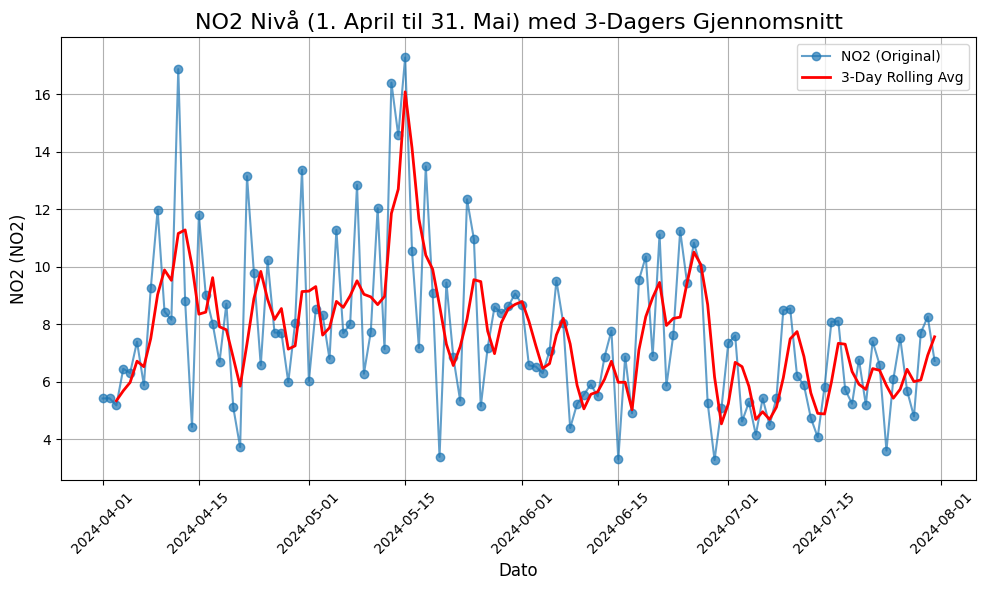

In [ ]:

filtered_df = Luftdata[(Luftdata["date"] >= "2024-04-01") & (Luftdata["date"] <= "2024-07-31")].copy()

variable = "NO2"

# Velger 3 dagers gjennomsnitt
avg_periode= 3
filtered_df.loc[:,f"{variable}_avg_periode"] = filtered_df[variable].rolling(window=avg_periode).mean()

# Opprinnelig data
plt.figure(figsize=(10, 6))
plt.plot(filtered_df["date"], filtered_df[variable], marker="o", label=f"{variable} (Original)", alpha=0.7)

# Plotter 3 dagers gjennomsnitt
plt.plot(filtered_df["date"], filtered_df[f"{variable}_avg_periode"], color="red", label=f"{avg_periode}-Day Rolling Avg", linewidth=2)

# Pynter og justerer
plt.title(f"{variable} Nivå (1. April til 31. Mai) med {avg_periode}-Dagers Gjennomsnitt", fontsize=16)
plt.xlabel("Dato", fontsize=12)
plt.ylabel(f"{variable} ({Luftdata[variable].name})", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

Her kan vi lettere se trender. Vi kan nå prøve å kombinere flere år å bare beholde "gjennomsnittslinjen" for hvert år uten den fullstendige dataen: 

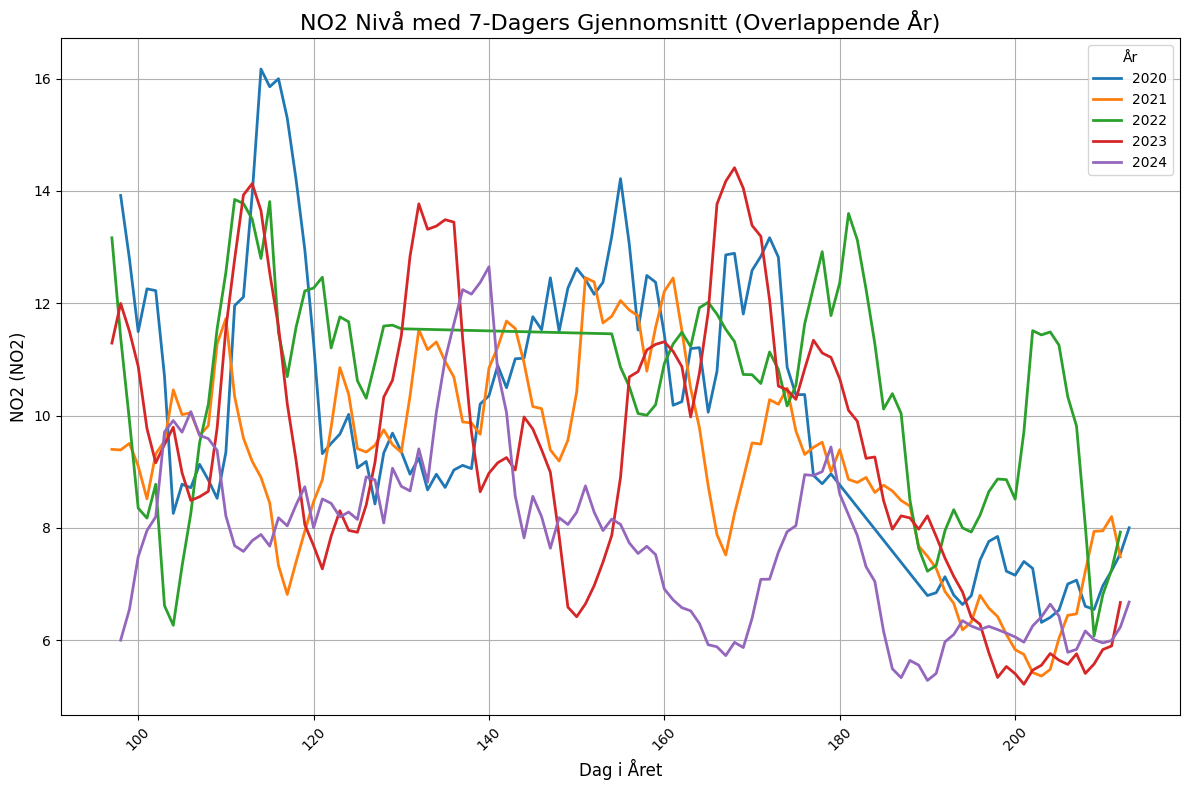

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

# Henter data fra fil
Luftdata = pd.read_json('../data/df1_fikset.json')

# Bytter til riktig datoformat
Luftdata["date"] = pd.to_datetime(Luftdata["date"])

# Få året
Luftdata["year"] = Luftdata["date"].dt.year

variable = "NO2"

# Gjennomsnittsvindu
avg_periode = 7

# Figur
plt.figure(figsize=(12, 8))

# Looper gjennom hvert år og lager gjennomsnitt
for year, group in Luftdata.groupby("year"):
    group = group.copy()
    group["day_of_year"] = group["date"].dt.day_of_year  # får datoene til å samsvare gjennom årene
    group[f"{variable}_avg_periode"] = group[variable].rolling(window=avg_periode).mean()
    
    # Plotter gjennomsnitt
    plt.plot(group["day_of_year"], group[f"{variable}_avg_periode"], label=f"{year}", linewidth=2)


plt.title(f"{variable} Nivå med {avg_periode}-Dagers Gjennomsnitt (Overlappende År)", fontsize=16)
plt.xlabel("Dag i Året", fontsize=12)
plt.ylabel(f"{variable} ({Luftdata[variable].name})", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title="År")


plt.tight_layout()
plt.show()

Pearson Correlation between mean(air_temperature P1D) and NO2: -0.03


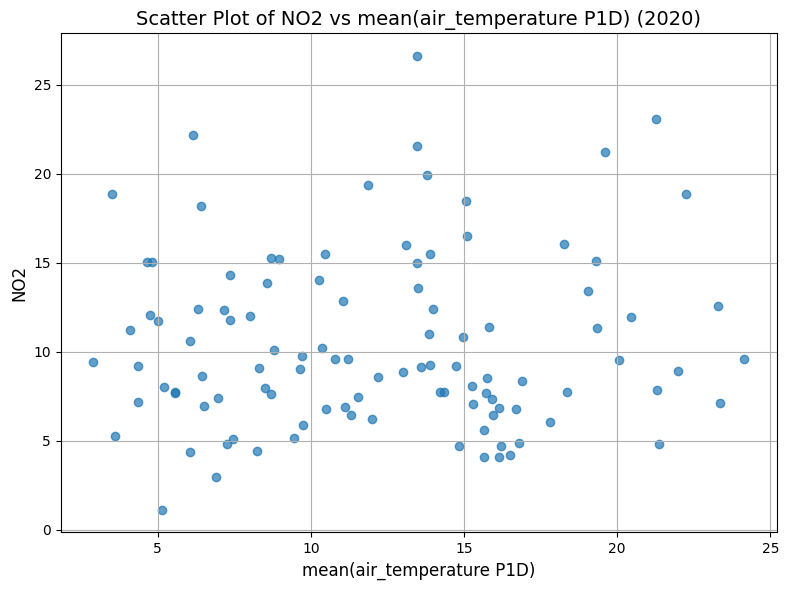

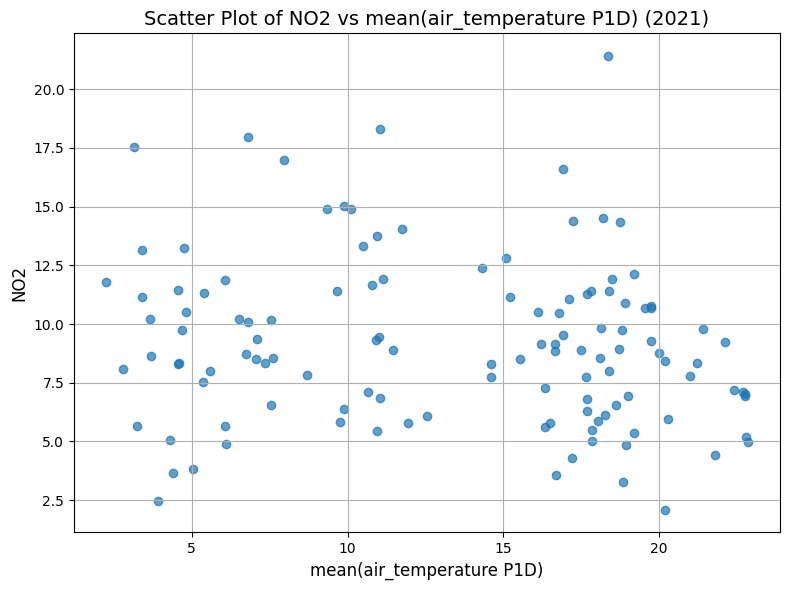

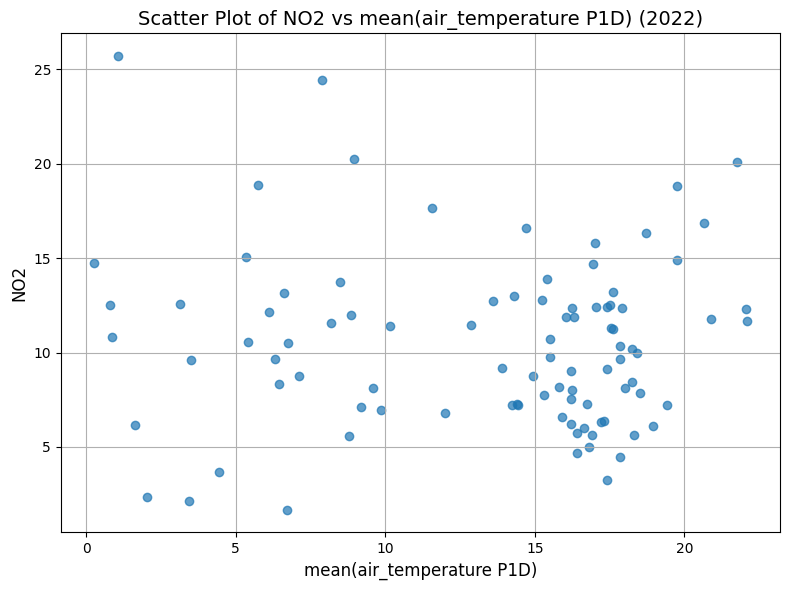

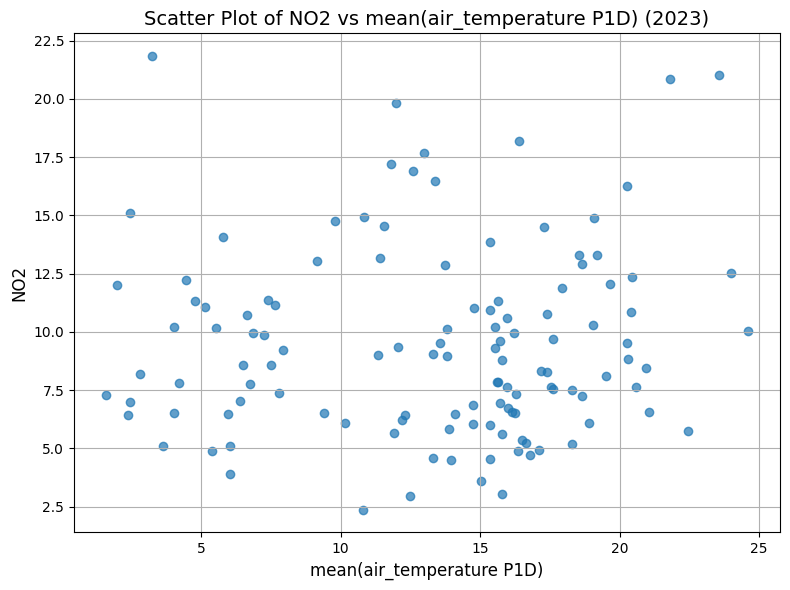

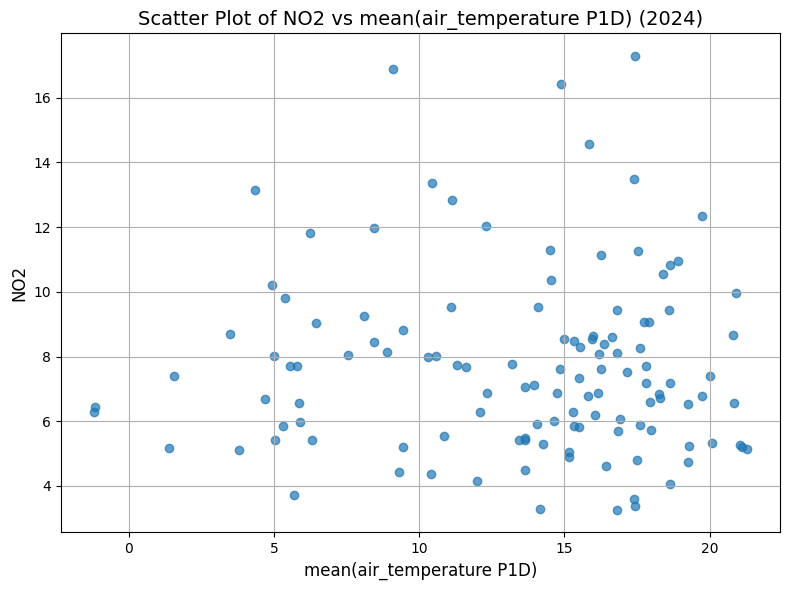

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Henter data
df1 = pd.read_json('../data/df1_data.json')
df2 = pd.read_json('../data/df2_data.json')

# Konverterer dato til riktig format
df1['date'] = pd.to_datetime(df1['date'], unit='ms')
df2['referenceTime'] = pd.to_datetime(df2['referenceTime'], unit='ms')

# Merger datasets
merged_df = pd.merge(df1, df2, left_on='date', right_on='referenceTime')

# Henter år for gruppering
merged_df['year'] = merged_df['date'].dt.year

# Variabler
x_variable = 'mean(air_temperature P1D)'  # Fra df2_data.json
y_variable = 'NO2'  # Fra df1_data.json

# correlation coefficient
correlation = merged_df[x_variable].corr(merged_df[y_variable])
print(f"Pearson Correlation between {x_variable} and {y_variable}: {correlation:.2f}")

# Plotter
for year, group in merged_df.groupby('year'):
    plt.figure(figsize=(8, 6))
    plt.scatter(group[x_variable], group[y_variable], alpha=0.7)
    plt.title(f'Scatter Plot of {y_variable} vs {x_variable} ({year})', fontsize=14)
    plt.xlabel(x_variable, fontsize=12)
    plt.ylabel(y_variable, fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()